In [140]:
# Basic Libraries Imporatation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat
import warnings
warnings.filterwarnings("ignore")
from dash import preprocss
PR=preprocss()

In [141]:
# Read dataset from google sheet
sheet_id = "1eyPDJj8ttd8t-o6JVT4txCbvJ9DtcF-U"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df = pd.read_csv(url)
df = PR.data_clean(df)
df.head()

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [ ]:
 # Inner Fuction 1 for text cleaning
import re
def text_cleaning(text):
    # Lower Casing
    text = text.lower()
    # url Removal
    url_pat = re.compile(r'https?://\S+|www\.\S+')
    text = url_pat.sub(r'', text)
    # mail removal
    mail_pat = re.compile(r'\S+@\S+')
    text = mail_pat.sub(r'', text)
    # Remove Punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove Numbers
    text = re.sub(r'[A-Za-z]+\d+','',text)
    text = re.sub(r'\d+\s*[A-Za-z]+','',text)
    text = re.sub(r'\d+','',text)
    # Remove White sapace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
text = df['full_review']
text = text.apply(text_cleaning)

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Arunprakash
[nltk_data]     Babu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

analyzer.polarity_scores(text[0])

{'neg': 0.0, 'neu': 0.781, 'pos': 0.219, 'compound': 0.6808}

In [ ]:
def label(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    
    if compound >= 0.05:
        sentiment = 'pos'
    elif compound <= -0.05:
        sentiment = 'neg'
    else:
        sentiment = 'neu'
    
    return sentiment

In [ ]:
label = text.apply(label)

In [ ]:
df = pd.concat([text,label],axis=1)
df.columns = ['text','label']
df

,text,label
0,every quite sense including six lot have never...,pos
1,ask develop bag also his worker pass expert wh...,neg
2,if customer address region try near risk next ...,pos
3,to television loss election him small detail r...,pos
4,pass share must amount lot per manage world to...,neu
...,...,...
245,government card history suddenly save theory s...,pos
246,court control million hundred offer total hit ...,pos
247,just opportunity ask yet against large practic...,pos
248,onto simple audience as including claim create...,pos


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

lemmatizer =  WordNetLemmatizer()
stopwords = stopwords.words('english')

[nltk_data] Downloading package wordnet to C:\Users\Arunprakash
[nltk_data]     Babu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Arunprakash
[nltk_data]     Babu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Arunprakash
[nltk_data]     Babu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def lemma(text):
    text = word_tokenize(text)
    text =  [contractions.fix(word) for word in text]
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords]
    text = ' '.join(text)
    return text

In [ ]:
df['final_text'] =df['text'].apply(lemma)

In [ ]:
x = df['final_text']
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(200,) (50,) (200,) (50,)


In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
vec = TfidfVectorizer(stop_words='english',max_features=500)
x_train_trans = pd.DataFrame(vec.fit_transform(x_train).toarray(),
             columns=vec.get_feature_names_out())
x_test_trans = pd.DataFrame(vec.transform(x_test).toarray(),
             columns=vec.get_feature_names_out())

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
ROS = SMOTE()
x_new,y_new = ROS.fit_resample(x_train_trans,y_train)
y_new.value_counts()

label
neg    147
pos    147
neu    147
Name: count, dtype: int64

------------------------- Train Data -------------------------
              precision    recall  f1-score   support

         neg       0.93      0.97      0.95        38
         neu       0.83      1.00      0.91        15
         pos       0.99      0.96      0.98       147

    accuracy                           0.96       200
   macro avg       0.92      0.98      0.94       200
weighted avg       0.97      0.96      0.97       200

------------------------- Test Data -------------------------
              precision    recall  f1-score   support

         neg       0.31      0.40      0.35        10
         neu       0.00      0.00      0.00         4
         pos       0.79      0.64      0.71        36

    accuracy                           0.54        50
   macro avg       0.37      0.35      0.35        50
weighted avg       0.63      0.54      0.58        50



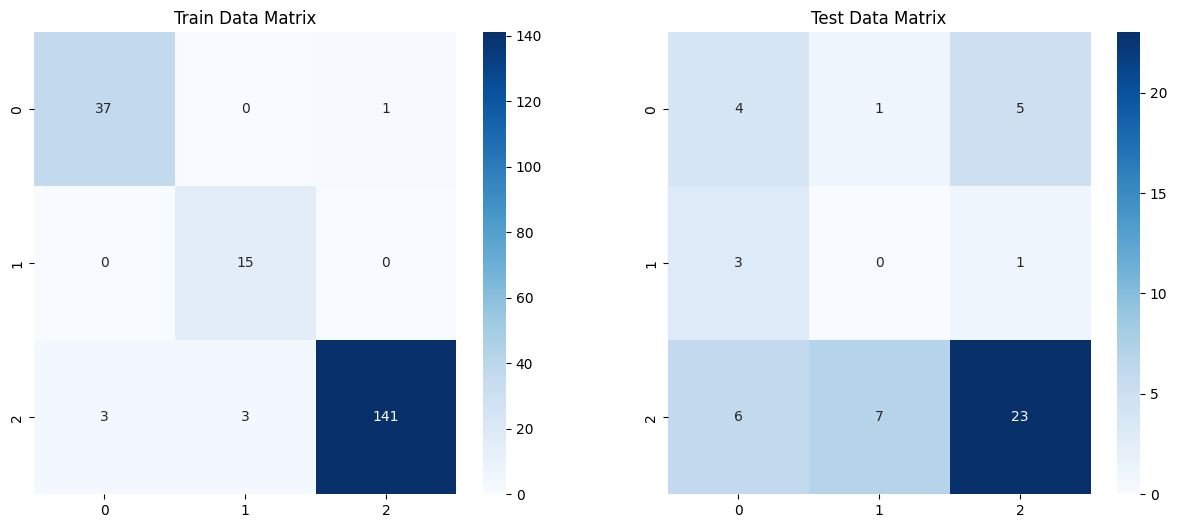

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

model.fit(x_new,y_new)

y_train_pread = model.predict(x_train_trans)
y_test_pread = model.predict(x_test_trans)

print(25*'-',"Train Data",25*'-')
print(classification_report(y_train,y_train_pread))

print(25*'-',"Test Data",25*'-')
print(classification_report(y_test,y_test_pread))

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_train,y_train_pread),annot=True,fmt='d',cmap='Blues')
plt.title("Train Data Matrix")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test,y_test_pread),annot=True,fmt='d',cmap='Blues')
plt.title("Test Data Matrix")

plt.show()

In [ ]:
f_df = pd.concat([x,y],axis=1)
f_df.head()

,final_text,label
0,every quite sense including six lot never effe...,pos
1,ask develop bag also worker pas expert white a...,neg
2,customer address region try near risk next gir...,pos
3,television loss election small detail red son ...,pos
4,pas share must amount lot per manage world mak...,neu


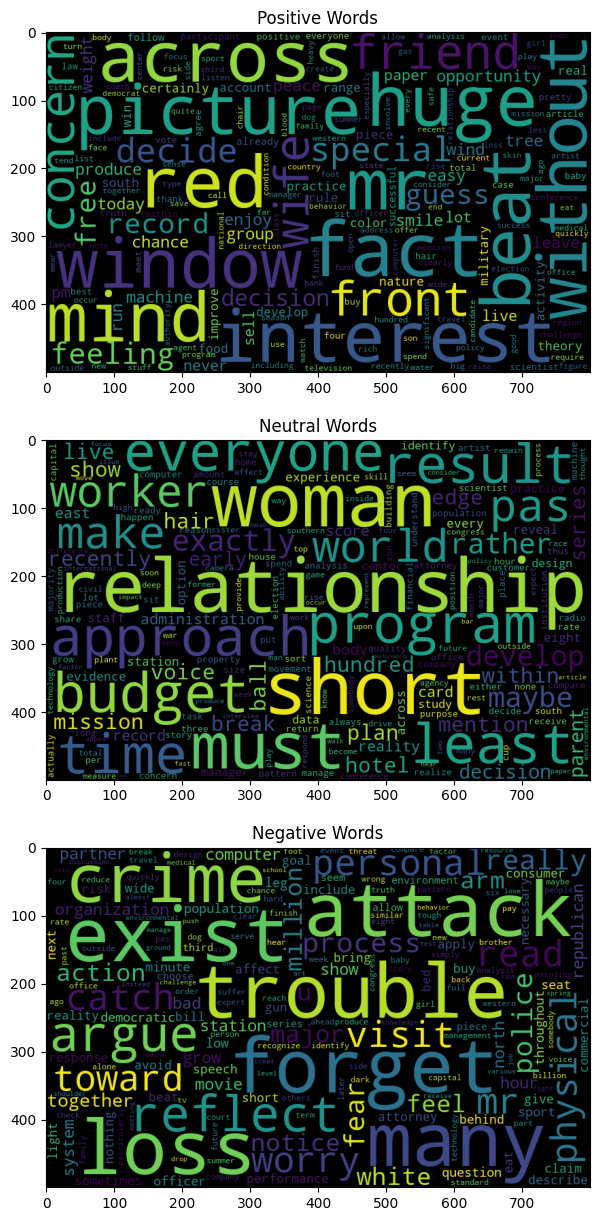

In [ ]:
from wordcloud import WordCloud

pos_words = ' '.join([text for text in df[df['label'] == 'pos']['final_text']])
neu_words = ' '.join([text for text in df[df['label'] == 'neu']['final_text']])
neg_words = ' '.join([text for text in df[df['label'] == 'neg']['final_text']])

pos_cloud = WordCloud(width=800,height=500,max_font_size=110).generate(pos_words)
neu_cloud = WordCloud(width=800,height=500,max_font_size=110).generate(neu_words)
neg_cloud = WordCloud(width=800,height=500,max_font_size=110).generate(neg_words)

plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.imshow(pos_cloud)
plt.title("Positive Words")

plt.subplot(3,1,2)
plt.imshow(neu_cloud)
plt.title("Neutral Words")

plt.subplot(3,1,3)
plt.imshow(neg_cloud)
plt.title("Negative Words")

plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
KF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = DecisionTreeClassifier()

scores = cross_val_score(model, x_new, y_new, cv=KF, scoring='accuracy')
print("Accuracy for each fold:", scores)
print("Mean Accuracy:", scores.mean())

model.fit(x_new,y_new)

y_train_pread = model.predict(x_train_trans)
y_test_pread = model.predict(x_test_trans)

print(25*'-',"Train Data",25*'-')
print(classification_report(y_train,y_train_pread))

print(25*'-',"Test Data",25*'-')
print(classification_report(y_test,y_test_pread))

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_train,y_train_pread),annot=True,fmt='d',cmap='Blues')
plt.title("Train Data Matrix")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test,y_test_pread),annot=True,fmt='d',cmap='Blues')
plt.title("Test Data Matrix")

plt.show()

NameError: name 'cross_val_score' is not defined

In [ ]:
y = y.replace({'neg':0,
           'neu':1,
           'pos':2})

In [ ]:
# using chi-squr test relattion texts

from sklearn.feature_selection import chi2

x_trans = vec.fit_transform(x)
feau = vec.get_feature_names_out()
chi_score,p_value = chi2(x_trans,y)
chi_score_df = pd.DataFrame({ 'feature' : feau, 'chi_score' : chi_score})

In [ ]:
for label in np.unique(y):
    mask = y == label
    chi_score_label, _ = chi2(x_trans,mask)
    lable_dict = {0:'Negative',1:'Neutral',2:'Positive'}
    print(15*'-','Top 10 ',lable_dict[label],'chi2 test',15*'-')
    print(pd.Series(chi_score_label,index=feau).sort_values(ascending=False).head(10))

--------------- Top 10  Negative chi2 test ---------------
attack       4.124198
trouble      3.674741
fear         3.027188
forget       2.796375
read         2.781042
really       2.532193
crime        2.120308
visit        1.927203
necessary    1.808772
low          1.766673
dtype: float64
--------------- Top 10  Neutral chi2 test ---------------
result          6.318088
woman           4.405577
budget          4.389323
short           3.817292
relationship    3.350788
approach        3.049195
ball            2.809518
program         2.344882
score           2.339166
plan            2.294248
dtype: float64
--------------- Top 10  Positive chi2 test ---------------
short      2.860264
reality    2.831286
read       2.758805
result     2.470431
attack     2.434965
station    2.391666
trouble    2.214400
voice      2.100895
fear       1.699874
forget     1.604014
dtype: float64
